<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/misc2(age_sex_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal: Build a joint deeplearning model which trains on ages and genders, to classify that of the fifth batch.** 
**Then ensemble this with deep learning prediction outputs of our best model to get the final classification**

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other imports to handle files
import os
import pickle
import csv

# deep learning imports
from keras.models import Sequential, load_model, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils, generic_utils, to_categorical
from keras.layers import LeakyReLU, Input, ReLU, concatenate
from keras import regularizers

# to split our dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# to mount our drive
from google.colab import drive

Using TensorFlow backend.


In [2]:
# mount google drive into google colab
drive.mount('/content/gdrive')

os.chdir('/content')

# go to where we will be working
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


**Run through our batches and train our model after building it**

In [4]:
## Loop through all our total slices and accumulate all the total slices info
training_batch_f = os.listdir('all_mprage_grappa/processed_brains/processed_brains_aug')[:3]
print (training_batch_f)

# build ultima total slices info
tsi_ultima = []

# load the pickle (train with 0 to 6)
for tbf in training_batch_f:
  with open('all_mprage_grappa/processed_brains/processed_brains_aug/'+tbf, 'rb') as f:
    total_slices, total_slices_info = pickle.load(f) # stored_batches/total_slices_batch5
    
    tsi_ultima.extend(total_slices_info)
    
print (np.shape(tsi_ultima))

['dbatch0.pkl', 'dbatch1.pkl', 'dbatch2.pkl']
(300, 4)


In [5]:
np.shape(tsi_ultima) # use this to train

(300, 4)

In [0]:
def get_classification(total_slices_info):
    '''get information of patient from total slices info'''
    classif = [s[2] for s in total_slices_info]
    classif = np.array(to_categorical(classif, 2))
    
    # now do the same for the sex, 'F' is 0, 'M' is 1
    sex = [s[1] for s in total_slices_info]
    for i in range(len(sex)):
        if sex[i] == 'F':
            sex[i] = 0
        if sex[i] == 'M':
            sex[i] = 1
    sex = np.array(to_categorical(sex, 2))
    
    # finally for age, one hot encode ages 0 to 100 (101 classes then)
    ages = [s[3] for s in total_slices_info]
    ages = np.array(to_categorical(ages, 101))
    
    return classif, sex, ages

y_train, sex_train, ages_train = get_classification(tsi_ultima)

In [31]:
def larger_info_dataset(df_path):
  '''Get the info from any given dataframe'''
  ## Get the classification of the y-values, sex and ages from a dataframe instead
  big_boi_df = pd.read_csv(df_path)

  # remove duplicate subject ids
  big_boi_df = big_boi_df.drop_duplicates(subset='Subject', keep='first')

  # map groups, control to 0, pd to 1. Also do this for sex, M is 1, F is 0
  big_boi_df = big_boi_df.replace({'Group': {'Control': 0, 'PD': 1}, 'Sex': {'M':1, 'F':0}})

  # split into training and test sets
  train_df, test_df = train_test_split(big_boi_df, test_size=0.10)

  print ("Train Size: %d, Test Size: %d" % (len(train_df), len(test_df)))

  # get the values for train
  ages_train = np.array(to_categorical(train_df['Age'].values,101))
  sex_train = np.array(to_categorical(train_df['Sex'].values, 2))
  y_train = np.array(to_categorical(train_df['Group'].values, 2))

  # get the values for test
  ages_test = np.array(to_categorical(test_df['Age'].values,101))
  sex_test = np.array(to_categorical(test_df['Sex'].values, 2))
  y_test = np.array(to_categorical(test_df['Group'].values, 2))
  
  return [ages_train, sex_train, y_train, ages_test, sex_test, y_test, big_boi_df]

ages_train, sex_train, y_train, ages_test, sex_test, y_test, big_boi_df = larger_info_dataset('all_mprage_grappa/Control_PD_6_21_2019.csv')

Train Size: 536, Test Size: 60


In [8]:
np.unique(to_binary(sex_train), return_counts=True)

NameError: ignored

In [0]:
big_boi_df.head()

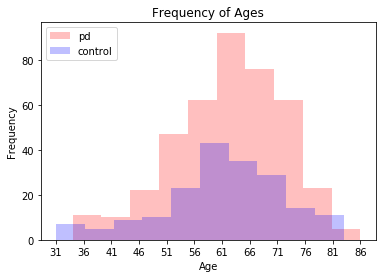

In [35]:
# plot for the ages
pd_df = big_boi_df[big_boi_df['Group'] == 1]
control_df =  big_boi_df[big_boi_df['Group'] == 0]

plt.hist(pd_df.Age, align='mid', alpha=0.25, color='r', label='pd', bins=10)
plt.hist(control_df.Age, align='mid', alpha=0.25, color='b', label='control', bins=10)
plt.legend(loc='upper left')

# set labels
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Frequency of Ages')

# set ticks
plt.xticks(np.arange(min(big_boi_df.Age), max(big_boi_df.Age)+1, 5.0))
# plt.savefig('figures/age_sex_ageFreq.png')
plt.show()

In [30]:
os.getcwd()

'/content/gdrive/My Drive/msc_project'

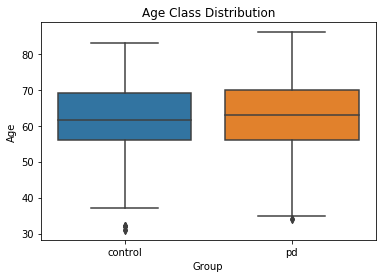

In [36]:
# some boxplots
ax = sns.boxplot(x="Group", y="Age", data=big_boi_df)
ax.set_xticklabels(['control', 'pd'])
plt.title("Age Class Distribution")
# plt.savefig('figures/age_sex_boxplot.png')
plt.show()

In [0]:
def create_mlp(dim, regress=False):
    '''Create our MLP network'''
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(2, activation="relu"))
 
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
 
    # return our model
    return model

In [0]:
def get_metrics(hist):
  ''' Function to get our metrics from history and score as inputs'''

  # actually obtain our metrics
  val_loss = hist.history['val_loss'][0]
  val_acc = hist.history['val_categorical_accuracy'][0]
  train_loss = hist.history['loss'][0]
  train_acc = hist.history['categorical_accuracy'][0]

  # put everything into one array
  return [val_loss, val_acc, train_loss, train_acc]

In [0]:
def to_binary(cat_array):
  '''Function to convert categorical back to binary values'''
  binary_output_array = []
  for i in range(len(cat_array)):
    binary_output_array.append(np.argmax(cat_array[i]))
    
  binary_output_array = np.array(binary_output_array)
  return binary_output_array

In [39]:
# creds: https://www.puzzlr.org/the-keras-functional-api-five-simple-examples/
# Create MLP models
mlp_sex = create_mlp(sex_train.shape[1], regress=False)
mlp_age = create_mlp(ages_train.shape[1], regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combined_input = concatenate([mlp_sex.output, mlp_age.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(8, activation="relu")(combined_input)
x = Dense(2, activation="sigmoid")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
as_model = Model(inputs=[mlp_sex.input, mlp_age.input], outputs=x)

W0729 07:33:50.713662 140320275679104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 07:33:50.769603 140320275679104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 07:33:50.779481 140320275679104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [40]:
as_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 2)            0                                            
__________________________________________________________________________________________________
dense_3_input (InputLayer)      (None, 101)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            24          dense_1_input[0][0]              
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 8)            816         dense_3_input[0][0]              
__________________________________________________________________________________________________
dense_2 (D

In [33]:
# compile our model
as_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-3, decay=1e-3 / 200), 
              metrics = ['categorical_accuracy']) # decay in Adam..

# train the model
print("training model...")
history = as_model.fit([sex_train, ages_train], y_train, validation_split=0.1, epochs=500, batch_size=150)

training model...
Train on 482 samples, validate on 54 samples
Epoch 1/500
482/482 [==============================] - 1s 3ms/step - loss: 0.5457 - categorical_accuracy: 0.7365 - val_loss: 0.6237 - val_categorical_accuracy: 0.6111
Epoch 2/500
482/482 [==============================] - 0s 36us/step - loss: 0.5430 - categorical_accuracy: 0.7365 - val_loss: 0.6281 - val_categorical_accuracy: 0.6111
Epoch 3/500
482/482 [==============================] - 0s 29us/step - loss: 0.5433 - categorical_accuracy: 0.7365 - val_loss: 0.6345 - val_categorical_accuracy: 0.6111
Epoch 4/500
482/482 [==============================] - 0s 34us/step - loss: 0.5425 - categorical_accuracy: 0.7365 - val_loss: 0.6427 - val_categorical_accuracy: 0.6111
Epoch 5/500
482/482 [==============================] - 0s 31us/step - loss: 0.5411 - categorical_accuracy: 0.7365 - val_loss: 0.6494 - val_categorical_accuracy: 0.6111
Epoch 6/500
482/482 [==============================] - 0s 29us/step - loss: 0.5406 - categorical_a

In [35]:
# test our model against the hidden one
score, acc = as_model.evaluate([sex_test, ages_test], y_test)

print ("Score: %.2f, Accuracy: %f" % (score, acc)) # just by running a deep learning model with the goddamn ages and gender, wtf

60/60 [==============================] - 0s 151us/step
Score: 0.81, Accuracy: 0.816667


In [36]:
## BUILD CONFUSION MATRIX
y_train_preds = as_model.predict([sex_train, ages_train])
y_train_real = y_train

y_test_preds = as_model.predict([sex_test, ages_test])
y_test_real = y_test

# Turn to binary outputs
y_train_preds_binary = to_binary(y_train_preds)
y_train_real_binary = to_binary(y_train_real)

y_test_preds_binary = to_binary(y_test_preds)
y_test_real_binary = to_binary(y_test_real)

# MAKE CONFUSION MATRIX, can also do the same for train data
print (confusion_matrix(y_train_real_binary, y_train_preds_binary))
print (confusion_matrix(y_test_real_binary, y_test_preds_binary))

[[ 49 128]
 [ 20 339]]
[[ 1  8]
 [ 3 48]]


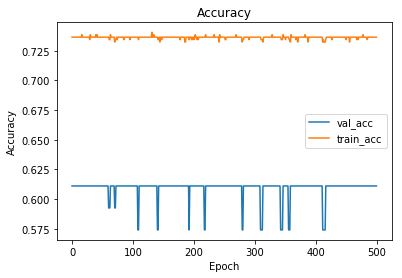

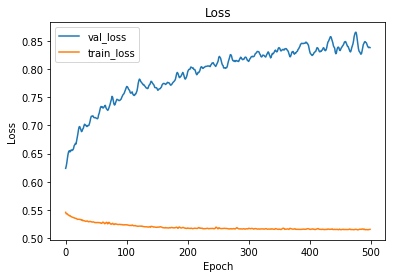

In [40]:
# Plot training & validation accuracy values
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_acc', 'train_acc'], loc='best')
# save
plt.savefig('all_mprage_grappa/z_tests/keep_models/as_model_plot_acc.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'train_loss'], loc='best')
# save
plt.savefig('all_mprage_grappa/z_tests/keep_models/as_model_plot_val.png')
plt.show()

In [0]:
# save our best model
pickle.dump( as_model, open( "all_mprage_grappa/z_tests/keep_models/as_model.pkl", "wb" ) )
# load model
# as_model = pickle.load( open( "all_mprage_grappa/z_tests/keep_models/as_model.pkl", "rb" ) )

**Testing our model with an independent batch of data**

In [0]:
# load our pickle batch of data
with open('all_mprage_grappa/processed_brains_aug/dbatch4.pkl', 'rb') as f: # also 'total_slices_all.pkl' ## RENAMED 5 TO 7, TESTING IT
  total_slices_test, total_slices_info_test = pickle.load(f) # stored_batches/total_slices_batch5

In [0]:
np.shape(total_slices_test)

(58, 160, 160, 160, 1)

In [0]:
# make the set an array
total_slices_test = np.array(total_slices_test)

# independent test
y_test, sex_test, ages_test = get_classification(total_slices_info_test)

In [0]:
# test our model against the independent set
score, acc = as_model.evaluate([sex_test, ages_test], y_test)

print ("Score: %.2f, Accuracy: %f" % (score, acc)) 

58/58 [==============================] - 0s 103us/step
Score: 0.73, Accuracy: 0.517241


**Make predictions with our as model**

In [0]:
as_train_preds = as_model.predict([sex_train, ages_train]) # this is what we will feed into next model
as_test_preds = as_model.predict([sex_test, ages_test]) # this is what we will use when testing

**Next part, get predictions from model on ages and sex and predictions from images, feed into another deep NN to try to predict the output, then test accuracy**

In [0]:
# ALTERNATIVELY: load our cnn_models
cnn_model = load_model('all_mprage_grappa/stored_models/model4x/model40_aug_v0.h5') # take 040, best performing one so far

W0624 16:17:28.772655 139906754799488 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#load batch slices, predict and aggregate scores
cnn_train_preds = []

# load the pickle (train with 0 to 3)
print (training_batch_f)
for tbf in training_batch_f:
  with open('all_mprage_grappa/processed_brains_aug/'+tbf, 'rb') as f:
    total_slices, total_slices_info = pickle.load(f) 
    # predict and aggregate
    total_slices = np.array(total_slices)
    
    # split and predict, too many to handle otherwise and will crash
    sub_arrays = np.array_split(total_slices, 50)
    
    for i in range(len(sub_arrays)):
      
      sub_array = sub_arrays[i]
      cnn_prediction = cnn_model.predict(sub_array)
      cnn_train_preds.extend(cnn_prediction)
    
print (np.shape(cnn_train_preds))

['dbatch0.pkl', 'dbatch1.pkl', 'dbatch2.pkl']
(300, 2)


In [0]:
# also get the test predictions
cnn_test_preds = cnn_model.predict(total_slices_test)

In [0]:
## Save our preds (cause it takes ages to build)
# pickle.dump( cnn_train_preds, open( "all_mprage_grappa/z_tests/cnn_training_preds.pkl", "wb" ) )
# pickle.dump( cnn_test_preds, open( "all_mprage_grappa/z_tests/cnn_test_preds.pkl", "wb" ) )
## load model
cnn_train_preds = pickle.load( open( "all_mprage_grappa/z_tests/cnn_training_preds.pkl", "rb" ) )
cnn_test_preds = pickle.load( open( "all_mprage_grappa/z_tests/cnn_test_preds.pkl", "rb" ) )

**Now make deep learning framework where we load our cnn train preds, our as train preds and aggregate**

In [0]:
def to_binary(cat_array):
  '''Function to convert categorical back to binary values'''
  binary_output_array = []
  for i in range(len(cat_array)):
    binary_output_array.append(np.argmax(cat_array[i]))
    
  binary_output_array = np.array(binary_output_array)
  return binary_output_array

In [0]:
# Create MLP models
mlp_cnn = create_mlp(2, regress=False) # value of 1 for binary, 2 for categorical
mlp_as = create_mlp(2, regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combined_input_two = concatenate([mlp_cnn.output, mlp_as.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
z = Dense(8, activation="relu")(combined_input_two)
z = Dropout(0.2)(z)
z = Dense(2, activation="sigmoid")(z)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
combined_model = Model(inputs=[mlp_cnn.input, mlp_as.input], outputs=z)

In [0]:
# compile our model
combined_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-3, decay=1e-3 / 200), 
              metrics = ['categorical_accuracy']) # decay in Adam..

# train the model
print("training model...")
combined_model.fit([cnn_train_preds, as_train_preds], y_train, validation_split=0.1, epochs=200)

training model...


ValueError: ignored

In [0]:
# pickle.dump( combined_model, open( "all_mprage_grappa/z_tests/combined_model_binary.pkl", "wb" ) )

**Load last one and test it out**

In [0]:
# get predictions of cnn_model on test data
# get predictions of as_model on test data
# input these predictions into our combined_model
# evaluate these against the actual y-value, pray it is not overfitted...

In [0]:
cm_score, cm_acc = combined_model.evaluate([cnn_test_preds, as_preds_test], y_test)

print ("Combined model score: %.2f, and combined model accuracy: %.2f" % (cm_score, cm_acc))

**Try: XGboosting the training predicted outputs**

In [0]:
from xgboost import XGBClassifier
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score

In [0]:
# convert everything to binary
cnn_train_preds_binary = to_binary(cnn_train_preds)
as_train_preds_binary = to_binary(as_preds_train)
y_train_binary = to_binary(y_train)

cnn_test_preds_binary = to_binary(cnn_preds_test)
as_test_preds_binary = to_binary(as_preds_test)
y_test_binary = to_binary(y_values_test)

In [0]:
np.shape(y_train_binary) # no worky

In [0]:
# make into a matrix and input this into our space

combined_zipped_train = list(zip(cnn_train_preds_binary, as_train_preds_binary))
combined_zipped_train = np.array(combined_zipped_train)

# fit model with training data
xgb_model = XGBClassifier()
xgb_model.fit(combined_zipped_train, y_train)

In [0]:
combined_zipped_test = list(zip(cnn_preds_test, as_preds_test))
combined_zipped_test = np.array(combined_zipped_test)

y_values_predictions = []
for i in range(len(combined_zipped_test)):
  cz_test_csr = csr_matrix(combined_zipped_test[i])
  xgb_preds = xgb_model.predict(cz_test_csr)
  y_values_predictions.append(xgb_preds)
  
y_values_predictions = np.array(y_values_predictions)

In [0]:
accuracy_score(y_values_test, y_values_predictions, normalize=True)

In [0]:
cnn_train_preds # train with this as an input
as_preds_train # another input
y_train # ideal output

#test
cnn_preds_test
as_preds_test
y_values_test


To try: reverse classification on each model and feed these in, see how our model holds up. Then do the same for our test and compare